# IMPORTS

In [ ]:
import pandas as pd
import os
os.system('pip install catboost lightgbm pip install statsmodels pip install xgboost pip install imblearn')
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split as tts
from imblearn.ensemble import BalancedBaggingClassifier  
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier 
from imblearn.ensemble import EasyEnsembleClassifier  
from imblearn.ensemble import RUSBoostClassifier 
from sklearn.metrics import precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek 
warnings.filterwarnings("ignore")

# Data processing

## Downloading Data

In [ ]:
x_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
defo = list(y_train.target)
x_train['y'] = defo
x_train = x_train[~(x_train.age == 0)]
x_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0


## Feature engineering

In [ ]:
des = x_train.describe()
des = des.append(pd.Series(data={ _:np.sum(np.isnan(x_train[_])) for _ in x_train.columns}, name='nans'), ignore_index= False)
des

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
count,105108.000000,105108.000000,105108.000000,105108.000000,8.411500e+04,105108.000000,105108.000000,105108.000000,105108.000000,102303.000000,105108.000000
mean,5.825221,53.321574,0.426637,354.191521,6.649734e+03,8.956283,0.269970,1.018505,0.244358,0.757084,0.066893
std,251.022624,14.810164,4.251245,1827.192531,1.106510e+04,5.182731,4.227386,1.136230,4.214038,1.116524,0.249838
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029591,42.000000,0.000000,0.173668,3.343188e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153790,53.000000,0.000000,0.365038,5.361671e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.554344,64.000000,0.000000,0.880885,8.207870e+03,12.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000
nans,0.000000,0.000000,0.000000,0.000000,2.099300e+04,0.000000,0.000000,0.000000,0.000000,2805.000000,0.000000


We can see that columns 'monthly_income' and 'family_members' has lots of nan's in it, so we should replace them. 

In [ ]:
crm = x_train.corr()
fig = px.imshow(crm)
fig.update_layout(paper_bgcolor="rgb(1,1,1,1)", font_color = "rgb(255, 255, 255)")
fig.show()

From the correlation matrix we can see that family members have correlation with age

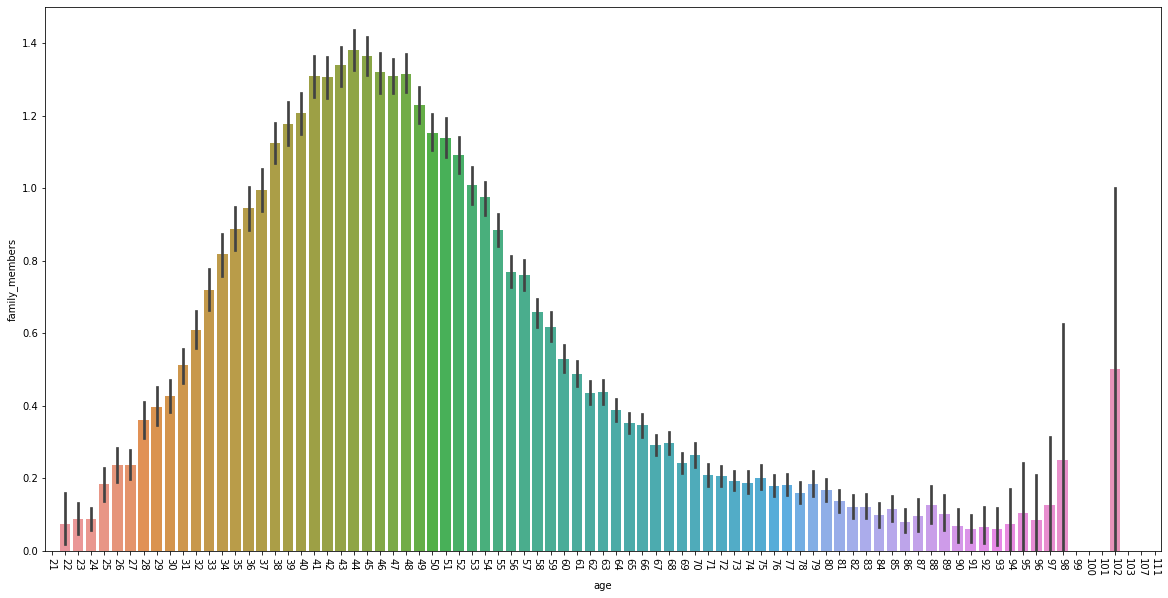

In [ ]:
plt.figure(figsize=[20,10])
plt.ylim(0, 1.5)
ax1 = sns.barplot("age", "family_members", data=x_train)
ax2 = ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-90)

As we can see the relationship between this variables, we can replace nan's with average family members for people of this age, rather than replace it with simple mean value from whole dataset. 

In [ ]:
for i in range(len(x_train.family_members)):
    if np.isnan(x_train.family_members.iloc[i]):
        x_train.family_members.loc[i] = np.mean(x_train.family_members[x_train.age == x_train.age.loc[i]])
x_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,y
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0


Also from the correlation matrix we can see that monthly income correlates with mortgage loans and credit loans, so we can make regression that will predict monthly income in missing points. 

In [ ]:
to_dro = ['credit_card_utilization', 'age', 'overdue_30_59_days', 'debt_to_income', 'monthly_income', 'overdue__more_than_90_days', 'family_members', 'overdue_60_89_days', 'y']
X = x_train.dropna().drop(columns=to_dro)
y = x_train.dropna()['monthly_income']
reg = sm.OLS(y, sm.add_constant(X)).fit()
x_train_cp = x_train[x_train.monthly_income.isna()]
pred = reg.predict(sm.add_constant(x_train_cp.drop(columns=to_dro)))
j = 0
for i in range(len(x_train.monthly_income)):
    if np.isnan(x_train.monthly_income.iloc[i]):
        x_train.monthly_income.loc[i] = pred.iloc[j]
        j+=1

Again using correlation matrix we can see we can see high correlation between three overdue columns. To avoid multicollinearity we can sum all this columns with coefficients 1,2,3 (more days of overdue - larger coefficient).

Also we can deal with family members. This variable seems to be useless on its own, but we can try to divide monthly income by it. 

Farther we can deal with debt/income. As we already have monthly income in the columns, then to avoid multicollinearity we can multiply monthly income by debt/income to have net debt in columns. 

In [ ]:
if 'debt' not in x_train.columns:
    x_train['debt'] = x_train.debt_to_income * x_train.monthly_income
    x_train.drop(columns=['debt_to_income'], inplace=True)

if 'overdue_30_59_days' in x_train.columns:
    x_train['overdue'] = 0
    x_train['overdue'] += x_train['overdue_30_59_days']
    x_train['overdue'] += x_train['overdue_60_89_days']*2
    x_train['overdue'] += x_train['overdue__more_than_90_days']*3

if 'overdue_30_59_days' in x_train.columns:
    x_train.drop(columns=['overdue_30_59_days', 'overdue_60_89_days', 'overdue__more_than_90_days'], inplace=True)

if 'family_members' in x_train.columns:
    x_train['monthly_income'] = x_train['monthly_income']/(x_train['family_members']+1)
    x_train.drop(columns=['family_members'], inplace=True)

# Machine learning

In [ ]:
x_train = x_train.dropna()
x, x_test, y, y_test = tts(x_train.drop(columns = 'y'), x_train.y, test_size=0.33, random_state=1)

For us, the most important thing is to minimize the number of real defaults that were classified as non-default, that is, after the selection of clients by the model, the bank would receive as few clients who would not be able to repay the loan, as possible. However, it is also important that the number of issued loans does not decrease significantly after the model has been run. That is why we will use two metrics to asses model's performance: FOR (False Ommition Rate) will show how many clients, of which the model offered to issue a loan, will be defaulters and FPR (False Positive Rate) will show how many of all non-defaulters were denied a loan by the model. By minimizing both metrics we will achieve the best model. 

In [ ]:
def FOR(model):
    cm = metrics.confusion_matrix(y_test, model.predict(x_test))
    result = cm[1][0]/(cm[1][0]+cm[0][0])
    return result
def FPR(model):
    cm = metrics.confusion_matrix(y_test, model.predict(x_test))
    result = cm[0][1]/(cm[0][1]+cm[0][0])
    return result

In [ ]:
rf = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(x,y)
print("Random forest percentage of defaulters accepted:", FOR(rf))
print("Random forest percentage of non-defaulters denied:",FPR(rf))

Random forest percentage of defaulters accepted: 0.06398406114250253
Random forest percentage of non-defaulters denied: 0.004930555555555555


We can see that in default setting there is very low percentage of non-defaulters denied, but there is also no significant decrease in percentage of defaulters accepted. It means that model is not quite good in terms of optimization of loan issuance. This happens because the target variable is unbalanced. Due to the fact that there are very few defaulters, therefore, the model offers to issue loans to almost everyone, which does not give us the opportunity to significantly improve our profitability. Therefore, we will work with an imbalance in the target.

## Dealing with imbalanced target

There are a few methods to deal with imbalanced target. We will try some under and over-sampling techniques as well as special models that rebalance target while fitting. Also we will try simply to increase treshold, oftentimes it is sufficient to have really good results. 

### Undersampling

**Undersampling is a group of techniques that consists of reducing the data by eliminating examples belonging to the majority class with the objective of equalizing the number of examples of each class.**

**Random undersampling**

In [ ]:
rus = RandomUnderSampler(random_state = 1)
X_res, y_res = rus.fit_resample(x, y)
rf_rus = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Undersampled random forest percentage of defaulters accepted:", FOR(rf_rus))
print("Undersampled random forest percentage of non-defaulters denied:",FPR(rf_rus))

Undersampled random forest percentage of defaulters accepted: 0.021671413314346744
Undersampled random forest percentage of non-defaulters denied: 0.23663194444444444


**Neighbourhood Cleaning Rule**

In [ ]:
ncr = NeighbourhoodCleaningRule()
X_res, y_res = ncr.fit_resample(x, y)
rf_ncr = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Undersampled random forest percentage of defaulters accepted:", FOR(rf_ncr))
print("Undersampled random forest percentage of non-defaulters denied:",FPR(rf_ncr))

Undersampled random forest percentage of defaulters accepted: 0.059992760061868565
Undersampled random forest percentage of non-defaulters denied: 0.008194444444444445


**Tomek links**

In [ ]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(x, y)
rf_tl = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Undersampled random forest percentage of defaulters accepted:", FOR(rf_tl))
print("Undersampled random forest percentage of non-defaulters denied:",FPR(rf_tl))

Undersampled random forest percentage of defaulters accepted: 0.06271275202932705
Undersampled random forest percentage of non-defaulters denied: 0.005694444444444445


**Instance Hardness Threshold**

In [ ]:
iht = InstanceHardnessThreshold(random_state=1)
X_res, y_res = iht.fit_resample(x, y)
rf_iht = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Undersampled random forest percentage of defaulters accepted:", FOR(rf_iht))
print("Undersampled random forest percentage of non-defaulters denied:",FPR(rf_iht))

Undersampled random forest percentage of defaulters accepted: 0.019256963036024612
Undersampled random forest percentage of non-defaulters denied: 0.2749652777777778


As we can see, Tomek Links and Neighbourhood Cleaning Rule do not improve situation significantly, while Random Undersampling and Instance Hardness Threshold do pretty good job, so they could be considered further. 

### Oversampling

**Random oversampler**

In [ ]:
ros = RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(x, y)
rf_ros = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Oversampled random forest percentage of defaulters accepted:", FOR(rf_ros))
print("Oversampled random forest percentage of non-defaulters denied:",FPR(rf_ros))

Oversampled random forest percentage of defaulters accepted: 0.02155843001289061
Oversampled random forest percentage of non-defaulters denied: 0.23569444444444446


**SMOTE**

In [ ]:
smt = SMOTE(random_state=1)
rf_smt = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Oversampled random forest percentage of defaulters accepted:", FOR(rf_smt))
print("Oversampled random forest percentage of non-defaulters denied:",FPR(rf_smt))

Oversampled random forest percentage of defaulters accepted: 0.02155843001289061
Oversampled random forest percentage of non-defaulters denied: 0.23569444444444446


**SMOTE Tomek**

In [ ]:
smtt = SMOTETomek()
X_res, y_res = smtt.fit_resample(x, y)
rf_smtt = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Oversampled random forest percentage of defaulters accepted:", FOR(rf_smtt))
print("Oversampled random forest percentage of non-defaulters denied:",FPR(rf_smtt))

Oversampled random forest percentage of defaulters accepted: 0.023422335331924254
Oversampled random forest percentage of non-defaulters denied: 0.21388888888888888


**ASASYN**

In [ ]:
ada = ADASYN(random_state=1)
X_res, y_res = ada.fit_resample(x, y)
rf_ada = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
print("Oversampled random forest percentage of defaulters accepted:", FOR(rf_ada))
print("Oversampled random forest percentage of non-defaulters denied:",FPR(rf_ada))

Oversampled random forest percentage of defaulters accepted: 0.023903536704453787
Oversampled random forest percentage of non-defaulters denied: 0.20173611111111112


We can see that all Oversampling techniques coped with the task of rebalancing, and showed an acceptable result, so all of them can be considered further.

### Models that rebalance target while fitting

**Balanced Random Forest**

In [ ]:
brf = BalancedRandomForestClassifier(max_depth=5, max_features=5,  random_state=1, n_estimators = 300).fit(x, y) 
print("Balanced Random Forest percentage of defaulters accepted:", FOR(brf))
print("Balanced Random Forest percentage of non-defaulters denied:",FPR(brf))

Balanced Random Forest percentage of defaulters accepted: 0.02197802197802198
Balanced Random Forest percentage of non-defaulters denied: 0.2243402777777778


**Balanced Bagging**

In [ ]:
bb = BalancedBaggingClassifier(random_state=1).fit(x, y) 
print("Balanced Bagging percentage of defaulters accepted:", FOR(bb))
print("Balanced Bagging percentage of non-defaulters denied:",FPR(bb))

Balanced Bagging percentage of defaulters accepted: 0.032891143191572374
Balanced Bagging percentage of non-defaulters denied: 0.13934027777777777


**EasyEnsembleClassifier**

In [ ]:
eec = EasyEnsembleClassifier(random_state=1).fit(x, y) 
print("Easy Ensemble percentage of defaulters accepted:", FOR(eec))
print("Easy Ensemble percentage of non-defaulters denied:",FPR(eec))

Easy Ensemble percentage of defaulters accepted: 0.02447023208879919
Easy Ensemble percentage of non-defaulters denied: 0.194375


**RUSBoostClassifier**

In [ ]:
rbc = RUSBoostClassifier(random_state=1).fit(x, y) 
print("RUSBoost percentage of defaulters accepted:", FOR(rbc))
print("RUSBoost percentage of non-defaulters denied:",FPR(rbc))

RUSBoost percentage of defaulters accepted: 0.026149759256184627
RUSBoost percentage of non-defaulters denied: 0.18534722222222222


Again we can see that all models have coped with the task of rebalancing, but it is really hard to asses them with default threshold, because some models are more prone to predict zeros, some are not. That is why we will use precision-recall curve to see how remaining 10 models perform with different tresholds. Also we will add a simple model without any resampling. We will limit graph from 0.2 to 1 on precision axis since we are not interested in lower values because precision shows us ratio of correctly predicted defaulters over all predicted defaulters, which means that very low value of it indicates that there are too many rejections and it will not lead to an increase in profit. 

## Model evaluation 

In [ ]:
def get_prc(model):
    lr_probs = model.predict_proba(x_test)[:, 1]
    yhat = model.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    return (lr_precision, lr_recall)

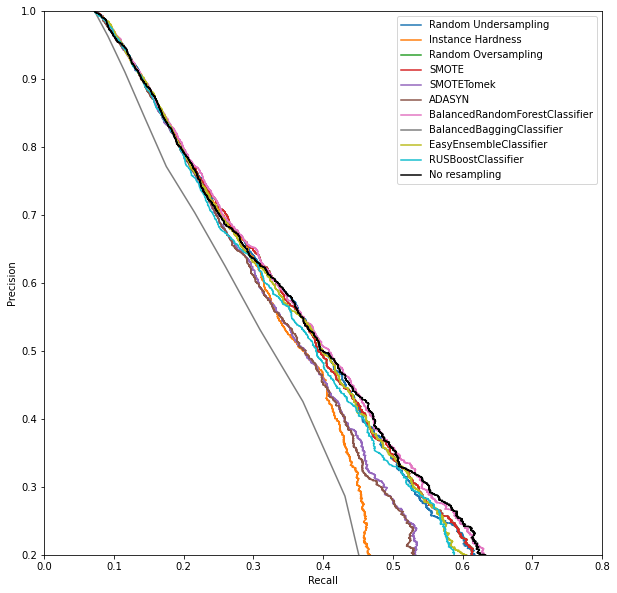

In [ ]:
mdls = [rf_rus, rf_iht, rf_ros, rf_smt, rf_smtt, rf_ada, brf, bb, eec, rbc]
names = ['Random Undersampling', 'Instance Hardness', 'Random Oversampling', 'SMOTE', 'SMOTETomek', 'ADASYN', str(brf).split('(')[0], str(bb).split('(')[0], str(eec).split('(')[0], str(rbc).split('(')[0]]
plt.figure(figsize=[10,10])

for i in range(len(mdls)):
    a,b = get_prc(mdls[i])
    plt.plot(a,b, label=names[i])

rf = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(x,y)
a,b = get_prc(rf)
plt.plot(a,b, label='No resampling', color = 'black')

plt.ylim([0.2, 1])
plt.xlim([0, 0.8])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

We can see that there are 5 models that perform better than others: No resampling, Easy Ensemble, Balanced Random Forest, Random Underdampling, Random Oversampling. Now we will test them in terms of best profit that they can give us. We will assume that average debt on credit card is the same for clients who default and not default. Also we will assume that that in case of default we lose all the money that client paid from his credit card and we will use interest rate of 20, because it is most near value to the real credit card interests in US dollars now.

**new FOR, FPR**

In [ ]:
def FOR(model, thrs):
    cm = metrics.confusion_matrix(y_test, (model.predict_proba(x_test)[:,1] > thrs).astype(int))
    result = cm[1][0]/(cm[1][0]+cm[0][0])
    return result
def FPR(model, thrs):
    cm = metrics.confusion_matrix(y_test, (model.predict_proba(x_test)[:,1] > thrs).astype(int))
    result = cm[0][1]/(cm[0][1]+cm[0][0])
    return result

# Profitability of the model

In [ ]:
def ins(n, i):
    return n[:i] + ' ' + n[i:]
def bnumber(n):
    n = str(n)
    for i in range(len(n)-3, 0, -3):
        n = ins(n, i)
    return n

In [ ]:
check = x_test.copy()
check['y'] = y_test
check['profit'] = 0
check['profit'][check.y == 0] = 0.2*(check[check.y == 0].monthly_income)/2
check['profit'][check.y == 1] = -1*(check[check.y == 1].monthly_income)/2
def_pro = check.profit.sum()
print('Revenue before using model:', bnumber(round(def_pro)))

Revenue before using model: 9 124 896


In [ ]:
mdls = [rf_rus, rf_ros, brf, eec, rf]
names = ['Random Undersampling', 'Random Oversampling', str(brf).split('(')[0], str(eec).split('(')[0], 'No resampling']
for j in range(len(mdls)):
    best = 0
    for i in np.arange(0.05, 0.91, 0.05):
        check['pred'] = mdls[j].predict_proba(x_test)[:,1]
        prft = check[check.pred <= i].profit.sum()
        if prft > best:
            best = prft
            bi = i
    print(names[j], f"Best revenue: {bnumber(round(best))},", "best threshold:", round(bi, 2))

Random Undersampling Best revenue: 10 427 315, best threshold: 0.7
Random Oversampling Best revenue: 10 391 970, best threshold: 0.7
BalancedRandomForestClassifier Best revenue: 10 401 801, best threshold: 0.7
EasyEnsembleClassifier Best revenue: 9 950 070, best threshold: 0.5
No resampling Best revenue: 10 382 196, best threshold: 0.15


We can see that we could consider further two most profitable models: Random Undersampling and Balanced Random Forest because they both reached 10 400 000 level.

Now, as one of two best resampling strategies is Random Undersampling we can use it not only with Random Forest, but try other models. 

In [ ]:
rus = RandomUnderSampler(random_state = 1)
X_res, y_res = rus.fit_resample(x, y)

**Light GBM**

In [ ]:
lgbm = LGBMClassifier(random_state=1, max_depth=4, n_estimators=100).fit(X_res, y_res)
best_lgbm = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = lgbm.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_lgbm:
        best_lgbm = prft
        bi_lgbm = i
print(f"Lgbm profit: {bnumber(round(best_lgbm))},", "best threshold:", round(bi_lgbm, 2))

Lgbm profit: 10 411 304, best threshold: 0.75


**CatBoost**

In [ ]:
cat = CatBoostClassifier(random_state=1, learning_rate = 0.05, iterations = 200, max_depth = 6, silent=True).fit(X_res, y_res)
best_cat = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = cat.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_cat:
        best_cat = prft
        bi_cat = i
# print('CatBoost profit:', round(best_cat), '\nBest threshold:', round(bi_cat, 2))
print(f"CatBoost profit: {bnumber(round(best_cat))},", "best threshold:", round(bi_cat, 2))


CatBoost profit: 10 440 709, best threshold: 0.75


**XGBoost**

In [ ]:
xgb = XGBClassifier(random_state=1, learning_rate = 0.05, max_depth = 2, min_child_weight = 6, eval_metric = 'logloss').fit(X_res, y_res)
best_xgb = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = xgb.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_xgb:
        best_xgb = prft
        bi_xgb = i
print(f"XGBoost profit: {bnumber(round(best_xgb))},", "best threshold:", round(bi_xgb, 2))
# print('XGBoost profit:', round(best_xgb), '\nBest threshold:', round(bi_xgb, 2))

XGBoost profit: 10 446 131, best threshold: 0.7


**Gradient Boosting Classifier**

In [ ]:
gbc = GradientBoostingClassifier(random_state=1, learning_rate = 0.003, max_depth = 3, n_estimators = 500, subsample = 0.4).fit(X_res, y_res)
best_gbc = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = gbc.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_gbc:
        best_gbc = prft
        bi_gbc = i
print(f"GBC profit: {bnumber(round(best_gbc))},", "best threshold:", round(bi_gbc, 2))
# print('GBC profit:', round(best_gbc), '\nBest threshold:', round(bi_gbc, 2))

GBC profit: 10 398 508, best threshold: 0.65


**Stacking with Random Forest**

In [ ]:
stc = StackingClassifier(estimators=[('rf',rf), ('xgb', xgb), ('cat', cat)], final_estimator=LogisticRegression()).fit(X_res, y_res)
best_stc = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = stc.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_stc:
        best_stc = prft
        bi_stc = i
print(f"Stacking with RF profit: {bnumber(round(best_stc))},", "best threshold:", round(bi_stc, 2))
# print('Stacking with RF profit:', round(best_stc), '\nBest threshold:', round(bi_stc, 2))

Stacking with RF profit: 10 492 735, best threshold: 0.75


**Stacking with Balanced Random Forest**

In [ ]:
stc2 = StackingClassifier(estimators=[('brf',brf), ('xgb', xgb), ('cat', cat)], final_estimator=LogisticRegression()).fit(X_res, y_res)
best_stc2 = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = stc2.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_stc2:
        best_stc2 = prft
        bi_stc2 = i
print(f"Stacking with balanced RF profit: {bnumber(round(best_stc2))},", "best threshold:", round(bi_stc2, 2))
# print('Stacking with RF profit:', round(best_stc2), '\nBest threshold:', round(bi_stc2, 2))

Stacking with balanced RF profit: 10 500 455, best threshold: 0.75


# Results

In [ ]:
rf = RandomForestClassifier(max_depth=5, random_state=0,max_features= 3,n_estimators = 300).fit(X_res,y_res)
best_rf = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = rf.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_rf:
        best_rf = prft
        bi_rf = i
print(f"Random Forest profit: {bnumber(round(best_rf))},", "best threshold:", round(bi_rf, 2))
# print('Random Forest profit:', round(best_rf), '\nBest threshold:', round(bi_rf, 2))

Random Forest profit: 10 427 315, best threshold: 0.7


In [ ]:
brf = BalancedRandomForestClassifier(max_depth=5, max_features=5,  random_state=1, n_estimators = 300).fit(x, y) 
best_brf = 0
for i in np.arange(0.05, 0.91, 0.05):
    check['pred'] = brf.predict_proba(x_test)[:,1]
    prft = check[check.pred <= i].profit.sum()
    if prft > best_brf:
        best_brf = prft
        bi_brf = i
print(f"Balanced Random Forest profit: {bnumber(round(best_brf))},", "best threshold:", round(bi_brf, 2))
# print('Balanced Random Forest profit:', round(best_brf), '\nBest threshold:', round(bi_brf, 2))

Balanced Random Forest profit: 10 401 801, best threshold: 0.7


In [ ]:
def iip (best_res):
    return f'{round(((best_res/def_pro)-1)*100, 2)}%'

In [ ]:
result = pd.DataFrame()
result['Model'] = ['Random Forest', 'Balanced Random Forest', 'XGBoost', 'CatBoost', 'Stacking with RF', 'Stacking with BRF']
result['Increase in revenue'] = [iip(best_rf), iip(best_brf), iip(best_xgb), iip(best_cat), iip(best_stc), iip(best_stc2)]
result['Accepted defaulters'] = [FOR(rf, bi_rf), FOR(brf, bi_brf), FOR(xgb, bi_xgb), FOR(cat, bi_cat), FOR(stc, bi_stc), FOR(stc2, bi_stc2)]
result['Denied non-defaulters'] = [FPR(rf, bi_rf), FPR(brf, bi_brf), FPR(xgb, bi_xgb), FPR(cat, bi_cat), FPR(stc, bi_stc), FPR(stc2, bi_stc2)]
result['Accepted defaulters'] = (100*result['Accepted defaulters']).apply(lambda x: str(round(x, 2)) + '%')
result['Denied non-defaulters'] = (100*result['Denied non-defaulters']).apply(lambda x: str(round(x, 2)) + '%')
result.sort_values(by='Increase in revenue', ignore_index=True, ascending=False)

,Model,Increase in revenue,Accepted defaulters,Denied non-defaulters
0,Stacking with BRF,15.07%,3.41%,8.27%
1,Stacking with RF,14.99%,3.42%,8.25%
2,XGBoost,14.48%,3.48%,8.12%
3,CatBoost,14.42%,3.69%,6.85%
4,Random Forest,14.27%,3.5%,8.02%
5,Balanced Random Forest,13.99%,3.55%,7.82%


We can see that with Stacking of Balanced Random Forest, Catboost and XGBoost we can get the best result by profit. Surprisingly, this model has been trained on resampled data (Stacking with Balanced Random Forest but trained on original data is not shown, but its result was worse), so we could conclude that additional balanced fitting after undersampling also has a positive influence to the model. This model gives us 15% increase in revenue, which is significant improvment for the bank. Also I would like to draw your attention on CatBoost model. Its financial result is as good as in the best model, but number of clients in this model greater than in others. Bank may use  this model if they are also interested in attracting clients to different products throught credit cards.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0365b271-6605-4524-ad1f-e00dd9a323c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>